In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

plt.rcParams['figure.figsize'] = 12.0, 8.0

from pyts.transformation import GADF,GASF
from sklearn.preprocessing import normalize

import uproot

import keras
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Concatenate, Dense, Activation, Reshape, Conv1D , Conv2D, MaxPooling1D, MaxPooling2D
from keras.layers import Dropout, Flatten, BatchNormalization, Embedding, LSTM, UpSampling1D

from keras.models import load_model

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def GAN():
    police = load_model("police.h5")
    thief = load_model("thief.h5")
    police.name = "police"
    thief.name = "thief"
    police.summary()
    thief.summary()
    gan = Sequential()
    gan.add(thief)
    police.trainable = False
    gan.add(police)
    gan.summary()
    return gan

gan = GAN()
China = load_model("thief.h5")


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4096)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4096, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 16)           1040      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 64, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4, 8)              8200      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2, 8)              0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 8)              4104      
__________

In [3]:


classes = 7
group = 5
training_ratio = 0.7
validation_ratio = 0.1
test_ratio = 0.2

def label(q,k):
    x = np.zeros(len(q))
    for i in range(len(q)):
        x[i] = k
    return x

def sep(q,k,z):
    y = label(q,k)
    x1, x2 ,x3 = np.split(q,[int(len(q)*training_ratio),int(len(q)*(training_ratio+validation_ratio))])
    y1, y2 ,y3 = np.split(y,[int(len(q)*training_ratio),int(len(q)*(training_ratio+validation_ratio))])
    if z == 0:
        return x1, y1
    if z == 1:
        return x2, y2
    if z == 2:
        return x3, y3
    
def comb(one,two,three,four,five,portion):
    one1,one2 = sep(one,0,portion)
    two1,two2 = sep(two,1,portion)
    three1,three2 = sep(three,2,portion)
    four1,four2 = sep(four,3,portion)
    five1,five2 = sep(five,4,portion)
#     six1,six2 = sep(six,5,portion)
#     seven1,seven2 = sep(seven,6,portion)
    
    z = np.concatenate((one1,two1,three1,four1,five1),axis=0)
    y = np.concatenate((one2,two2,three2,four2,five2),axis=0)
    return z, y

def reader_pmtall(path):
    extra = np.arange(4096, 4480)
    
    tree = uproot.open(path)["tree"]
    pmtall = tree.array("PMTALL")
    pmtall = np.delete(pmtall, extra, axis=1)
    return pmtall

def reader(path,branch,number):
    tree = uproot.open(path)["tree"]
    column = tree.array(branch)
    column = column[:,number]
    return column

def reader_lone(path,branch):
    tree = uproot.open(path)["tree"]
    column = tree.array(branch)
    return column

def pmtall_pedestal(path):
    pedestal = reader(path,"Pedestal",0)
    pmtall = reader_pmtall(path)
    for i in range(len(pedestal)):
        pmtall[i] = -(pmtall[i]-pedestal[i])
    
    return pmtall

def generator(x):
    while 1:
        alpha = pmtall_pedestal("Alpha.root")
#         bad1 = pmtall_pedestal("BAD_DATA_QUALITY_1.root")
#         bad2 = pmtall_pedestal("BAD_DATA_QUALITY_2.root")
        piled = pmtall_pedestal("Piled_2.root")
        ls = pmtall_pedestal("LS.root")
        lsbeta = pmtall_pedestal("lsbeta.root")
        ref = pmtall_pedestal("RefPulse009.root")
        
        z1, z2 = comb(piled,ref,alpha,ls,lsbeta,x)
        s = np.random.permutation(np.arange(len(z2)))
        z1 = z1[s]
        z2 = z2[s]
        
#         print(len(z1))

#         para_piled = parameters("Piled_2.root")
#         para_ref = parameters("RefPulse009.root")
#         para_alpha = parameters("Alpha.root")
#         para_ls = parameters("LS.root")
#         para_lsbeta = parameters("lsbeta.root")
        
#         z3, z4 = comb5(para_piled,para_ref,para_alpha,para_ls,para_lsbeta,x)        
#         z3 = z3[s] 
#         z4 = z4[s]

        gasf = GASF(image_size=128, overlapping=False, scale='-1')
        
        for i in range(len(z2)):
            d1 = np.expand_dims(z1[i],axis=0)
            q = keras.utils.to_categorical(z2[i],classes)
            r = normalize(d1,norm="l1")
#             s = np.expand_dims(q,axis=0)
            yield r

test = generator(0)
# print(next(test)[0][0])
print(next(test)[0].shape)
# print(next(test)[0][1].shape)
# print(next(test)[1].shape)

(4096,)


In [4]:
%time
predicted = gan.predict_generator(generator(0),max_queue_size=100,steps=2000,verbose=1)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 9.06 µs
2000/2000 [==============================] - 43s 21ms/step


In [5]:
print(predicted[:100])
print(predicted.argmax(axis=1)[:100])

[[1.1010488e-03 9.9873322e-01]
 [0.0000000e+00 1.0000000e+00]
 [3.1216508e-03 9.9654824e-01]
 [1.1236016e-37 1.0000000e+00]
 [2.0428591e-25 1.0000000e+00]
 [2.4914697e-02 9.7413695e-01]
 [0.0000000e+00 1.0000000e+00]
 [1.7508683e-03 9.9802125e-01]
 [0.0000000e+00 1.0000000e+00]
 [4.6189874e-03 9.9496752e-01]
 [0.0000000e+00 1.0000000e+00]
 [8.4377117e-03 9.9099076e-01]
 [1.4634989e-35 1.0000000e+00]
 [0.0000000e+00 1.0000000e+00]
 [2.6355878e-02 9.7269195e-01]
 [0.0000000e+00 1.0000000e+00]
 [3.6066188e-04 9.9956650e-01]
 [0.0000000e+00 1.0000000e+00]
 [6.3419938e-02 9.3622410e-01]
 [9.6997195e-33 1.0000000e+00]
 [3.7921868e-02 9.6117944e-01]
 [1.5742904e-02 9.8346347e-01]
 [8.3461531e-02 9.1679639e-01]
 [4.1774572e-30 1.0000000e+00]
 [7.0612714e-02 9.2923218e-01]
 [9.6665593e-03 9.8971599e-01]
 [1.4395929e-02 9.8484564e-01]
 [9.4958888e-03 9.8989266e-01]
 [8.9608133e-03 9.9044752e-01]
 [1.3665127e-03 9.9844092e-01]
 [1.9254996e-02 9.7987247e-01]
 [4.9600657e-03 9.9461043e-01]
 [1.2430

In [6]:
def standard(x,height,decay):
    y = height*np.exp(-x*decay)
    return y

def shifter(x,starts):
    L = int(starts*len(x))
    y = np.zeros(len(x))
    y[:L] = np.zeros(L) 
    y[L:] = x[:(len(x)-L)]
    return y

def comb_standard(x,second,height_1,decay_1,height_2,decay_2):
    L = int(second*len(x))
    y = np.zeros(len(x))
    y[:L] = standard(x[:L],height_1,decay_1)
    y[L:] = standard(x[:(len(x)-L)],height_2,decay_2)
    return y

def noiser(x,strength):
    y = x + np.random.normal(0,strength,len(x))
    return y

def noiser_long(x,strength):
    noise = np.random.normal(0,strength,len(x))
    y = x + np.cumsum(noise)*strength
    return y

def noiser_comb(x,sepfact,strength):
    L = int(sepfact*len(x))
    x[:L] = noiser(x[:L],strength)
    x[L:] = noiser_long(x[L:],strength)
    return x

def array_maker(entries):
    x = np.arange(0,1,1/4096)
    x = np.expand_dims(x,axis=0)
    x = np.tile(x,[entries,1])
    return x

def double(x,second,height_1,decay_1,height_2,decay_2,starts,sepfact=0.15,strength=0.02):
    y = comb_standard(x,second,height_1,decay_1,height_2,decay_2)
    y = shifter(y,starts)
    y = noiser_comb(y,sepfact,strength)
    return y

def single(x,height,decay,starts,sepfact=0.15,strength=0.02):
    y = standard(x,height,decay)
    y = shifter(y,starts)
    y = noiser_comb(y,sepfact,strength)
    return y

def event_creators_single(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(1,0.01)
        r = np.random.normal(5,2)
        s = np.random.normal(0.03,0.005)
        x[i] = single(x[i],w,r,s)
    return x

def event_creators_single_2(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(1,0.01)
        r = np.random.normal(10,2)
        s = np.random.normal(0.03,0.005)
        x[i] = single(x[i],w,r,s)
    return x

def event_creators_single_3(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(1,0.1)
        r = np.random.normal(4,1)
        s = np.random.normal(0.03,0.005)
        x[i] = single(x[i],w,r,s)
    return x

def event_creators_sharp(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(1,0.01)
        r = np.random.normal(100,20)
        s = np.random.normal(0.03,0.005)
        x[i] = single(x[i],w,r,s)    
    return x

def event_creators_double_equal(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(0.2,0.01)
        p = np.random.normal(1,0.01)
        q = np.random.normal(5,2)
        r = np.random.normal(1,0.01)
        s = np.random.normal(5,2)
        t = np.random.normal(0.03,0.005)
        x[i] = double(x[i],w,p,q,r,s,t)
    return x
    
def event_creators_double_unequal(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(0.2,0.01)
        p = np.random.normal(1,0.2)
        q = np.random.normal(50,10)
        r = np.random.normal(1,0.2)
        s = np.random.normal(50,10)
        t = np.random.normal(0.03,0.005)
        x[i] = double(x[i],w,p,q,r,s,t)
    return x

def event_creators_sharp_fat(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(0.015,0.001)
        p = np.random.normal(1,0.2)
        q = np.random.normal(100,20)
        r = np.random.normal(0.2,0.05)
        s = np.random.normal(5,2)
        t = np.random.normal(0.03,0.005)
        x[i] = double(x[i],w,p,q,r,s,t)
    return x

In [7]:
def gen_fake(x):
    while 1:
        beta = event_creators_single(1000)
        ls = event_creators_sharp(1000)
        dp_e = event_creators_double_equal(1000)
        dp_ue = event_creators_double_unequal(1000)
        lsbeta = event_creators_sharp_fat(1000)
        
        alpha = event_creators_single_2(1000)
        gamma = event_creators_single_3(1000)
        
        z1, z2 = comb(beta,ls,dp_e,alpha,gamma,x)
        s = np.random.permutation(np.arange(len(z2)))
        z1 = z1[s]
        z2 = z2[s]
#         print(len(z1))
        gasf = GASF(image_size=128, overlapping=False, scale='-1')
        
        for i in range(len(z2)):
            d1 = np.expand_dims(z1[i],axis=0)
#             p = gasf.transform(d1)
            q = keras.utils.to_categorical(z2[i],classes)
            r = normalize(d1,norm="l1")
            yield r,r



In [8]:
%time
predicted = gan.predict_generator(gen_fake(0),max_queue_size=100,steps=2000,verbose=1)
print(predicted[:100])
print(predicted.argmax(axis=1)[:100])

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 9.06 µs
2000/2000 [==============================] - 24s 12ms/step
[[6.00140356e-02 9.39533114e-01]
 [2.90989466e-02 9.69948709e-01]
 [1.29056359e-02 9.86375391e-01]
 [2.59457588e-01 7.43432581e-01]
 [1.00000000e+00 1.63957613e-16]
 [2.63558049e-02 9.72692013e-01]
 [2.08893940e-02 9.78208482e-01]
 [3.92712168e-02 9.59844708e-01]
 [1.95533689e-02 9.79568243e-01]
 [4.37556714e-01 5.68691969e-01]
 [1.00000000e+00 4.40972705e-14]
 [1.19667966e-02 9.87340987e-01]
 [4.26044732e-01 5.80215812e-01]
 [1.23386919e-01 8.77913356e-01]
 [9.99999881e-01 7.19516535e-08]
 [4.02497407e-03 9.95591700e-01]
 [7.29603589e-01 2.72404015e-01]
 [1.13207638e-01 8.87986600e-01]
 [8.25621560e-02 9.17664886e-01]
 [2.13848799e-02 9.77705061e-01]
 [1.32064810e-02 9.86066282e-01]
 [1.87662896e-02 9.80371118e-01]
 [9.81047470e-03 9.89566863e-01]
 [1.48272244e-02 9.84402776e-01]
 [1.14903651e-01 8.86308789e-01]
 [1.74385626e-02 9.81727481e-01]
 [5.38373739e-03 9.

In [9]:
%time
predicted = China.predict_generator(generator(0),max_queue_size=100,steps=2000,verbose=1)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 10 µs
2000/2000 [==============================] - 40s 20ms/step


(1, 4096)
1/1 [==============================] - 0s 24ms/step


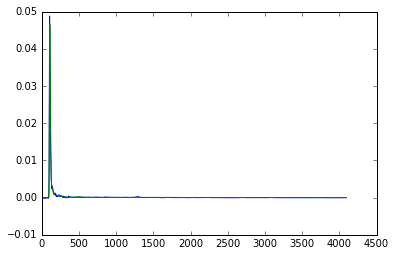

(1, 4096)
1/1 [==============================] - 0s 24ms/step


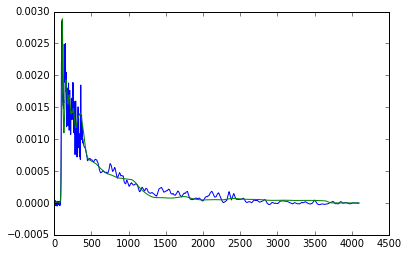

(1, 4096)
1/1 [==============================] - 0s 23ms/step


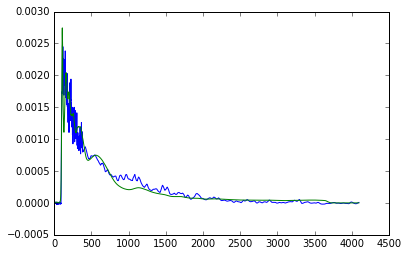

(1, 4096)
1/1 [==============================] - 0s 23ms/step


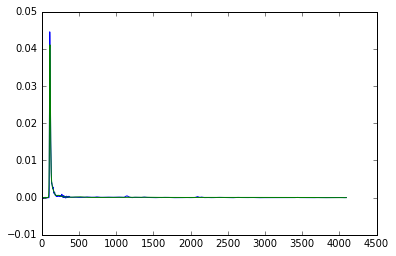

(1, 4096)
1/1 [==============================] - 0s 23ms/step


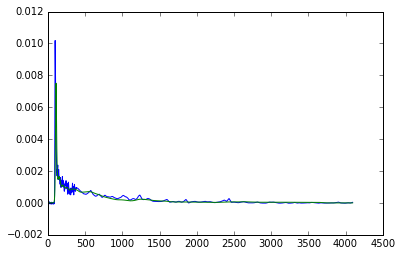

(1, 4096)
1/1 [==============================] - 0s 23ms/step


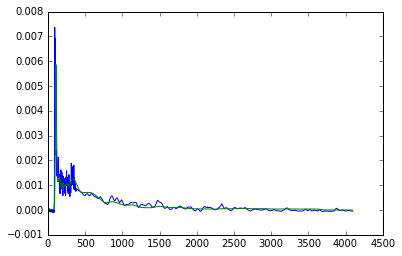

(1, 4096)
1/1 [==============================] - 0s 23ms/step


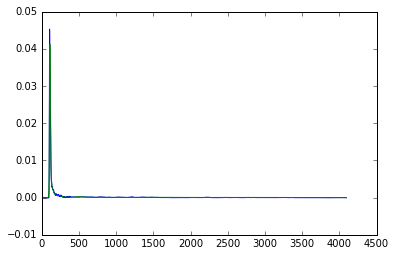

(1, 4096)
1/1 [==============================] - 0s 23ms/step


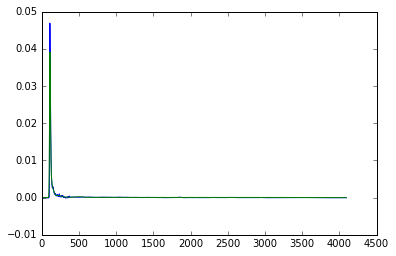

(1, 4096)
1/1 [==============================] - 0s 23ms/step


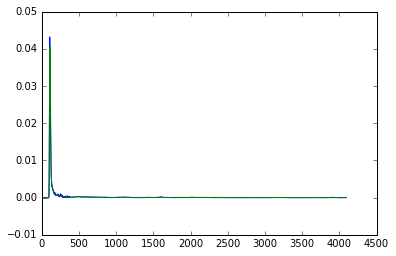

(1, 4096)
1/1 [==============================] - 0s 23ms/step


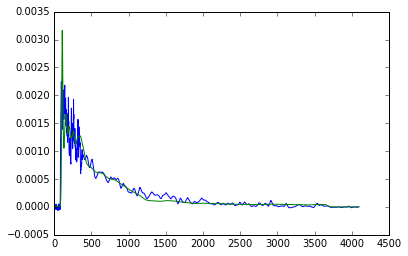

(1, 4096)
1/1 [==============================] - 0s 33ms/step


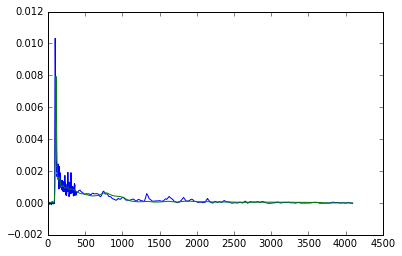

(1, 4096)
1/1 [==============================] - 0s 24ms/step


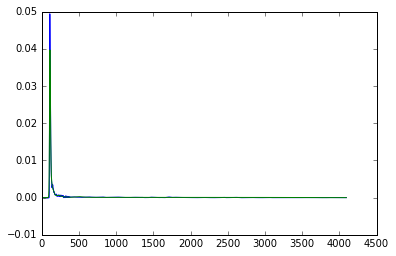

(1, 4096)
1/1 [==============================] - 0s 23ms/step


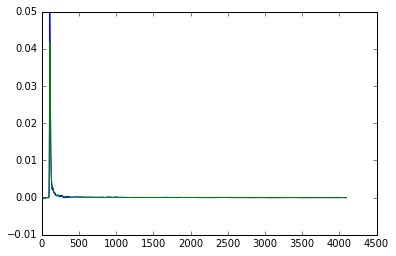

(1, 4096)
1/1 [==============================] - 0s 23ms/step


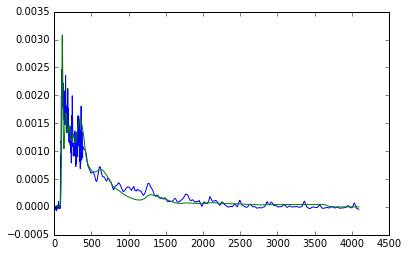

(1, 4096)
1/1 [==============================] - 0s 23ms/step


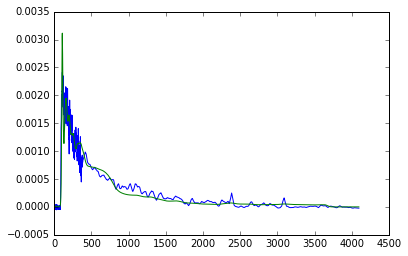

(1, 4096)
1/1 [==============================] - 0s 23ms/step


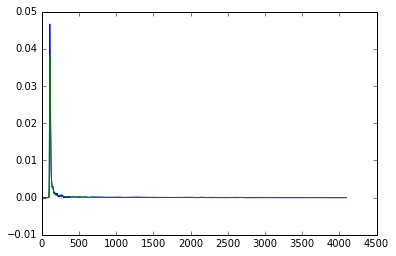

(1, 4096)
1/1 [==============================] - 0s 23ms/step


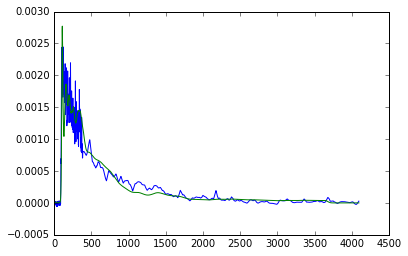

(1, 4096)
1/1 [==============================] - 0s 23ms/step


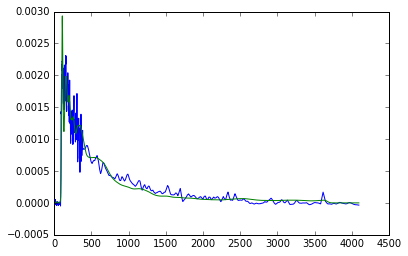

(1, 4096)
1/1 [==============================] - 0s 23ms/step


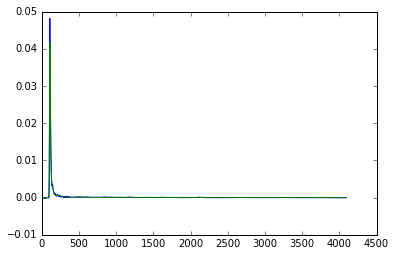

(1, 4096)
1/1 [==============================] - 0s 27ms/step


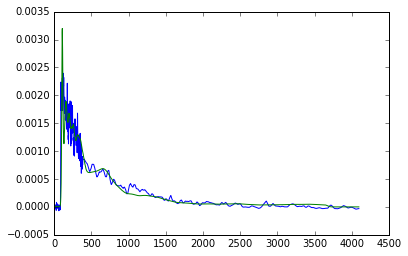

In [11]:
for i in range(20):
    X1 = next(generator(0))
    print(X1.shape)
    X2 = China.predict(X1,verbose=1)
    plt.figure()
    plt.plot(X1[0])
    plt.plot(X2[0])
    plt.show()
    